## Group Project Report: Predicting Heart Disease Using knn classification
Nethkini Liyanage - Charlotte Du - Andrew Young Liu - Vivian Khong

In [1]:
#load packages
library(tidyverse)
library(tidymodels)
library(dplyr)
library(gridExtra)

# set the seed
set.seed(1)


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

# Introduction:
Heart disease pertains to be one of the major causes of death (1 in 5) in America and many other countries. Factors including cholesterol, blood pressure, and blood sugar levels, among many others, are critical indicators of heart disease risk and contribute to narrowing arteries and reducing blood flow to the heart, increasing the chances of heart attacks and other cardiovascular complications. Managing these levels is crucial in preventing heart disease.  Using medical equipment such as X-rays and ECGs is too costly and is not readily available to be used across the world. The “Heart Disease” dataset donated by researchers at the Department of Medicine, Veterans Administration Medical Center, Long Beach California in 1988 includes 14 attributes and a target variable indicating the presence or absence of heart disease. The dataset contains data from patient test groups from Switzerland, America, and Hungary. This project utilizes the database from Cleveland, Ohio to determine if cases of heart disease can be accurately classified using  maximum heart rate achieved during exercise (thalach), ST depression induced by exercise relative to rest (oldpeak), and number of major vessels (ca). 

## Preliminary exploratory data analysis:
- Loading Data into R
- Cleaning and wrangling training data
- Summary tables of class distribution and training data
- Visualizations 

In [2]:
#Step 1: load data to R

# Set the URL where the dataset is located
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                  "thalach", "exang", "oldpeak", "slope", "ca", "thal", "heart_disease_presence")
# Read the data into R
cleveland_data <- read.csv(url, header = FALSE, col.names = column_names)

# View the first few rows of the data
head(cleveland_data)
nrow(cleveland_data)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease_presence
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
6,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


[1] 303

In [3]:
#Convert 0 to 'no' and 1-3 to 'yes' in a new column
cleveland_data$heart_disease_presence <- ifelse(cleveland_data$heart_disease_presence == 0, 'no', 'yes')

# Convert the column types
cleveland_data <- mutate(cleveland_data, ca = as.numeric(ca), 
    heart_disease_presence = as.factor(heart_disease_presence))

#see first 6 rows to check the effect
head(cleveland_data)
nrow(cleveland_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `ca = as.numeric(ca)`.
Caused by warning:
! NAs introduced by coercion”


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease_presence
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
1,63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,no
2,67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,yes
3,67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,yes
4,37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,no
5,41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,no
6,56,1,2,120,236,0,0,178,0,0.8,1,0,3.0,no


[1] 303

In [4]:
#Step 3:split the data to 75% training and 25% testing
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = heart_disease_presence)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

#show traning data
nrow(cleveland_train)

[1] 227

In [5]:
#notice that there are some rows that have "?"
question_mark__count <- data.frame(t(colSums(cleveland_train == "?", na.rm = TRUE))) # need to modify this to output proper count
question_mark__count

#delete these rows
cleveland_train <- filter(cleveland_train, thal != "?")

#filter out na's
cleveland_train <- na.omit(cleveland_train)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease_presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [6]:
# Summary table with count of observations, mean of predictors, and count of missing data
summary_table <- cleveland_train |>
  summarise(
    Count_Yes = sum(heart_disease_presence == "yes"),
    Count_No = sum(heart_disease_presence == "no"),
    Mean_trestbps = mean(trestbps),
    Mean_thalach = mean(thalach),
    Mean_oldpeak = mean(oldpeak),
    Mean_chol = mean(chol),
    Mean_ca = mean(ca),
    Total_Missing_Data = sum(rowSums(is.na(cleveland_train)))
  )

# To view the table
summary_matrix <- as.matrix(summary_table)
summary_matrix

Count_Yes,Count_No,Mean_trestbps,Mean_thalach,Mean_oldpeak,Mean_chol,Mean_ca,Total_Missing_Data
104,120,132.8036,149.3973,1.054018,247.3259,0.7008929,0


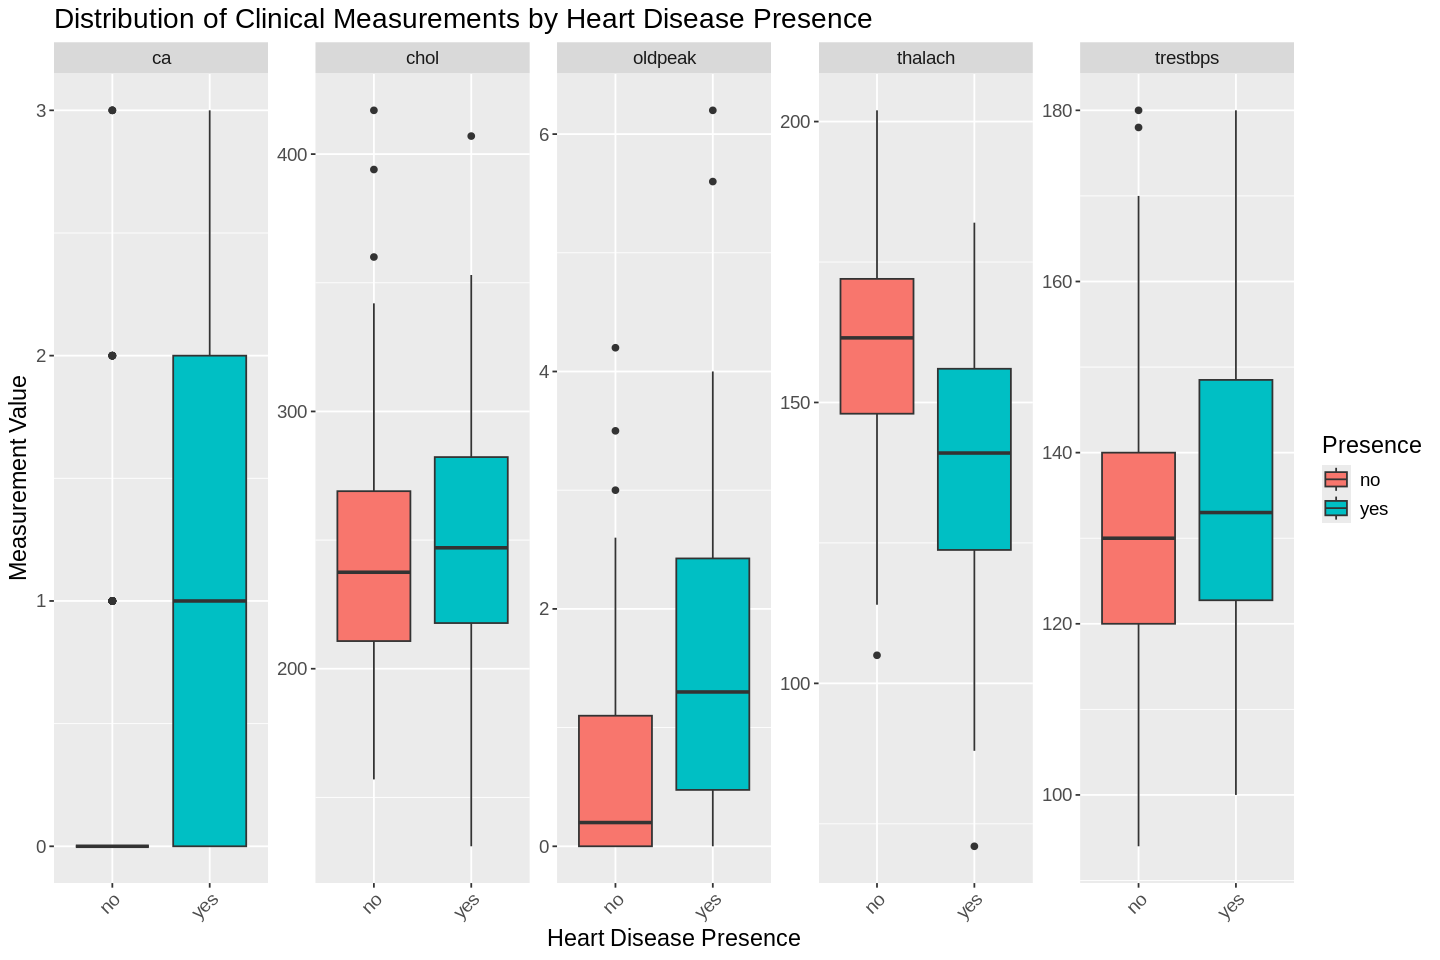

In [7]:
#visualization of the data
options(repr.plot.width=12, repr.plot.height=8)
long_data <- cleveland_train |>
  pivot_longer(cols = c(trestbps, thalach, oldpeak, chol, ca), names_to = "variable", values_to = "value")

ggplot(long_data, aes(x = heart_disease_presence, y = value, fill = heart_disease_presence)) +
  geom_boxplot() +
  facet_wrap(~variable, scales = 'free', ncol = 5) +
  labs(x = "Heart Disease Presence", y = "Measurement Value", fill = "Presence", title = "Distribution of Clinical Measurements by Heart Disease Presence") +
  theme(text = element_text(size = 14), axis.text.x = element_text(angle = 45, hjust = 1))

From the barplot we conclude that we will use only ca, oldpeak and thalach because they seem to differ a lot in the boxplot between different heart presence.

## Methods:
The goal of this project is to build a model that can predict whether or not a patient has heart disease.
The model will use the K-nearest neighbors classification algorithm, as it is the most suitable method for the task; our data contains many variables, and we are trying to sort patients into two distinct categories. 

The data contains many variables, and not all of them can be used in the classification. The most relevant data can be characterized by:
- Being in numeric form (some categorical data could work)
- Moderate to strong correlations with heart disease

Additionally, as the model is being made to reduce the need for medical tests, variables that can be measured using simple and minimally invasive procedures are favoured (but this is not a priority).
To determine which variables should be prioritized, scatter plots between different variables can be used to find correlation strengths. 

We will use the K-nearest neighbors algorithm to analyze our data. Based on the preliminary data analysis, the data must be standardized and centered. Then, to determine the appropriate K value for our model, we will use cross-validation. To evaluate the performance of our model, we can use a confusion matrix and calculate the accuracy, precision and recall.
Additionally, to account for the fact that diseases behave differently in male and female bodies, we will make bar graphs to determine variability between sexes, and do some data analysis separated by sex.



## Expected Outcomes and Significance:

Elevated serum cholesterol heightens the risk of arterial plaque buildup, impeding blood flow and increasing the risk of clot formation. Elevated blood pressure impairs vessel elasticity, diminishing blood flow and augmenting heart disease susceptibility, manifesting as chest pain. Consequently, we anticipate finding relationships/ correlations between our 5 predictor variables and the presence or absence of heart disease. It is likely that factors like high serum cholesterol levels, resting blood pressure, and maximum heart rate achieved during exercise correlate positively with heart disease. This study harbours the potential for a cost-effective heart disease classification alternative. Furthermore, mitigating factors contributing to elevated serum cholesterol and blood pressure can enhance preventive measures against heart disease. Future inquiries could explore the interplay of various factors in heart disease diagnosis. For instance, “Are there specific age ranges where certain predictor variables exhibit a stronger association with the presence of heart disease?” and “Is there a sex difference where certain predictor variables exhibit a stronger association with the presence of heart disease?”


